In [1]:
import os
import json
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the API key and set the model name
file_path = "../keys.json"
with open(file_path, "r", encoding="utf-8") as file:
    key_data = json.load(file)

os.environ["OPENAI_API_KEY"] = key_data["openai_api_key"]
model_name = "gpt-4o-mini"

llm = ChatOpenAI(temperature=0, model_name=model_name)


In [3]:
# Load the dataset JSON file
data_path = "../data/tqa_train_val_test/train/tqa_v1_train.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# For a quick check, print the first record
print(data[0])

{'adjunctTopics': {'Apply Concepts': {'content': {'figures': [], 'mediaLinks': [], 'text': '5. A glacier is melting. What are all of the scientists you can think of who might be involved in studying this glacier? What would each of them do? '}, 'orderID': 't_12'}, 'Introduction': {'content': {'figures': [{'caption': 'FIGURE 1.10 Earth as seen from Apollo 17.', 'imagePath': 'textbook_images/earth_science_and_its_branches_20010.png'}], 'mediaLinks': [], 'text': 'Earth Science is the study of all aspects of our planet Earth. Earth Science is not just about the molten lava, icy mountain peaks, steep canyons and towering waterfalls of the continents. Earth Science includes the atmosphere and oceans. The field also looks out into the solar system, galaxy, and universe. Earth scientists seek to understand the beautiful planet on which we depend (Figure 1.10). Different branches of Earth Science study one particular part of Earth. Since all of the branches are connected, specialists work toget

In [4]:
def extract_textbook_text(entry):
    """
    Extract textbook text from a TQA dataset entry.
    Retrieves text from the 'adjunctTopics' and 'topics' sections.
    """
    texts = []
    
    # Extract text from adjunctTopics
    adjunct_topics = entry.get("adjunctTopics", {})
    for topic in adjunct_topics.values():
        content = topic.get("content", {})
        text = content.get("text", "")
        if text:
            texts.append(text.strip())
            
    # Extract text from topics
    topics = entry.get("topics", {})
    for topic in topics.values():
        content = topic.get("content", {})
        text = content.get("text", "")
        if text:
            texts.append(text.strip())
    
    return texts

In [5]:
# Combine the extracted text from the first record
extracted_texts = extract_textbook_text(data[0])
combined_text = "\n\n".join(extracted_texts)
print("Combined Text:\n")
print(combined_text)

Combined Text:

5. A glacier is melting. What are all of the scientists you can think of who might be involved in studying this glacier? What would each of them do?

Earth Science is the study of all aspects of our planet Earth. Earth Science is not just about the molten lava, icy mountain peaks, steep canyons and towering waterfalls of the continents. Earth Science includes the atmosphere and oceans. The field also looks out into the solar system, galaxy, and universe. Earth scientists seek to understand the beautiful planet on which we depend (Figure 1.10). Different branches of Earth Science study one particular part of Earth. Since all of the branches are connected, specialists work together to answer complicated questions. Lets look at some important branches of Earth Science.

Describe Earth Science and its branches.
Identify the field of geology as a branch of Earth Science that deals with the rocks and minerals of Earth.
Describe the field of oceanography as a branch of Earth S

In [18]:
########################
# 1. Generate Mindmap  #
########################
def generate_mindmap(text, llm, max_tokens=300):
    """
    Generate a mind map in Mermaid syntax for the given text using ChatOpenAI (or similar LLM).
    The mind map should capture the main topics and their subtopics in a clear hierarchical structure.
    IMPORTANT: We instruct the model not to use a generic 'root' node, but rather a relevant main topic
    as the central node for better readability.
    """
    prompt = (
        "Generate a mind map in Mermaid syntax for the following textbook text. "
        "The mind map should capture the main topics and their subtopics clearly in a hierarchical structure. "
        "Do NOT include a 'root' node; use a meaningful central topic. "
        "Include minimal Mermaid syntax so it renders correctly, and keep it concise.\n\n"
        f"{text}\n\n"
        "Mermaid Mind Map:"
    )
    
    result = llm.invoke(prompt, max_tokens=max_tokens)
    mindmap = result.content.strip()
    return mindmap

In [19]:
############################
# 2. Clean Mermaid Code    #
############################
def clean_mermaid_code(code):
    """
    Remove ```mermaid code fences or other markdown backticks.
    Ensures the CLI sees only valid Mermaid syntax.
    """
    lines = code.splitlines()
    # Remove lines that start with ```
    lines = [line for line in lines if not line.strip().startswith("```")]
    return "\n".join(lines)

In [15]:
##############################
# 3. Render Mermaid Diagram  #
##############################
def render_mermaid(mindmap_code, output_filename='mermaid_output.svg', theme='forest'):
    """
    Render Mermaid diagram as an SVG file using the Mermaid CLI (mmdc).
    You can specify a theme for better visualization (e.g., 'forest', 'dark', 'neutral', etc.).
    """
    # Write Mermaid code to a temporary file
    temp_file = "temp_mermaid.mmd"
    with open(temp_file, "w", encoding="utf-8") as f:
        f.write(mindmap_code)
    
    # Call the Mermaid CLI with a chosen theme
    subprocess.run(
        ["mmdc", "-i", temp_file, "-o", output_filename, "-t", theme],
        check=True
    )
    
    # Display the generated SVG inline (Jupyter/IPython)
    display(SVG(output_filename))
    
    # Clean up the temporary file
    os.remove(temp_file)


In [20]:
# Generate the Mermaid mind map for the combined textbook text
mindmap_code = generate_mindmap(combined_text, llm)
print("\nGenerated Mind Map (Mermaid format):\n")
print(mindmap_code)


Generated Mind Map (Mermaid format):

```mermaid
mindmap
  Earth Science
    Description
      Study of Earth's aspects
      Includes atmosphere and oceans
      Connected branches
    Branches
      Geology
        Study of rocks and minerals
        Processes of Earth
        Specializations
          Mineralogy
          Volcanology
          Seismology
          Paleontology
          Planetary geology
      Oceanography
        Study of oceans
        Water movement and chemistry
        Branches
          Physical oceanography
          Marine geology
          Chemical oceanography
          Marine biology
      Meteorology
        Study of atmosphere
        Weather patterns and climate
        Climatology
      Environmental Science
        Human impact on environment
        Ecology
      Astronomy
        Study of solar system and universe
        Tools and methods
        Questions about the universe
    Importance
      Understanding Earth
      Addressing global issues


Cleaned Mermaid code:
mindmap
  Earth Science
    Description
      Study of Earth's aspects
      Includes atmosphere and oceans
      Connected branches
    Branches
      Geology
        Study of rocks and minerals
        Processes of Earth
        Specializations
          Mineralogy
          Volcanology
          Seismology
          Paleontology
          Planetary geology
      Oceanography
        Study of oceans
        Water movement and chemistry
        Branches
          Physical oceanography
          Marine geology
          Chemical oceanography
          Marine biology
      Meteorology
        Study of atmosphere
        Weather patterns and climate
        Climatology
      Environmental Science
        Human impact on environment
        Ecology
      Astronomy
        Study of solar system and universe
        Tools and methods
        Questions about the universe
    Importance
      Understanding Earth
      Addressing global issues
      Collaboration with oth

[@zenuml/core] Store is a function and is not initiated in 1 second.


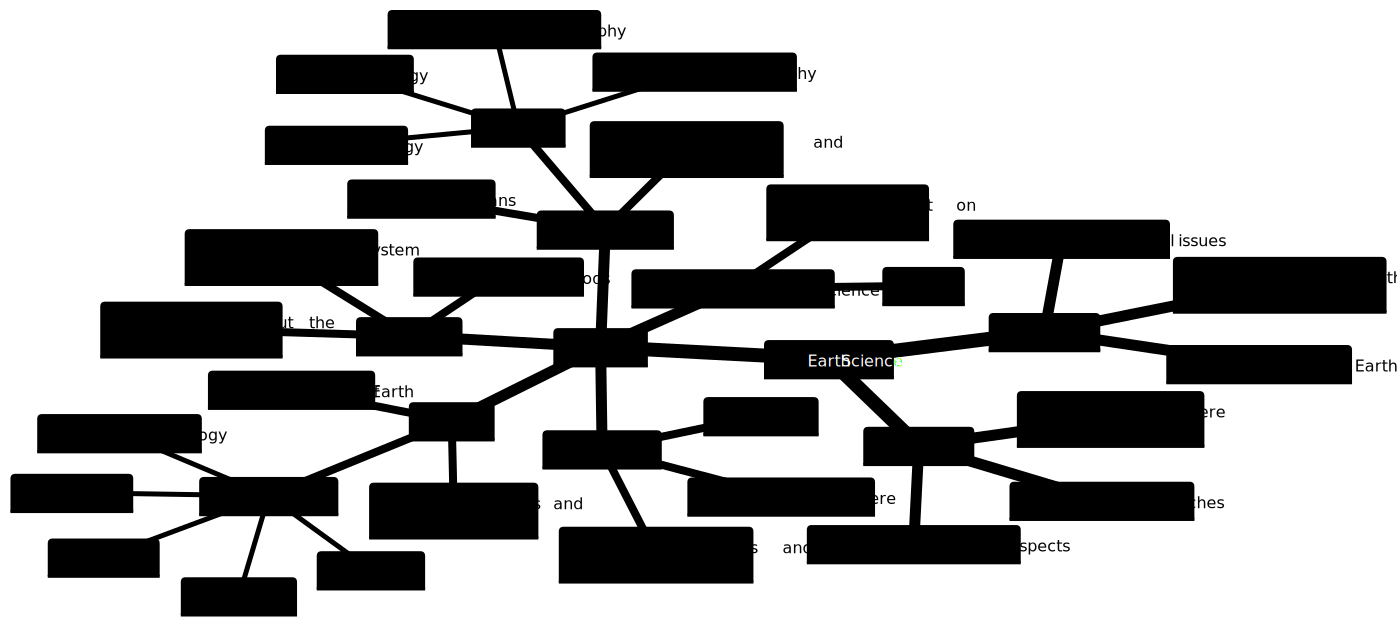

In [21]:

# 2) Clean code to remove markdown fences
cleaned_code = clean_mermaid_code(mindmap_code)
print("Cleaned Mermaid code:")
print(cleaned_code)

# 3) Render with the desired theme (e.g., 'forest', 'dark', 'neutral')
render_mermaid(cleaned_code, 'mermaid_output.svg', theme='forest')